# Attention Pooling by Similarity


Now that we have introduced the primary components of the attention mechanism, let's use them in a rather classical setting, namely regression and classification via kernel density estimation :cite:`Nadaraya.1964,Watson.1964`. This detour simply provides additional background: it is entirely optional and can be skipped if needed. 
At their core, Nadaraya--Watson estimators rely on some similarity kernel $\alpha(\mathbf{q}, \mathbf{k})$ relating queries $\mathbf{q}$ to keys $\mathbf{k}$. Some common kernels are

$$\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}
$$

There are many more choices that we could pick. See a [Wikipedia article](https://en.wikipedia.org/wiki/Kernel_(statistics)) for a more extensive review and how the choice of kernels is related to kernel density estimation, sometimes also called *Parzen Windows* :cite:`parzen1957consistent`. All of the kernels are heuristic and can be tuned. For instance, we can adjust the width, not only on a global basis but even on a per-coordinate basis. Regardless, all of them lead to the following equation for regression and classification alike:

$$f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

In the case of a (scalar) regression with observations $(\mathbf{x}_i, y_i)$ for features and labels respectively, $\mathbf{v}_i = y_i$ are scalars, $\mathbf{k}_i = \mathbf{x}_i$ are vectors, and the query $\mathbf{q}$ denotes the new location where $f$ should be evaluated. In the case of (multiclass) classification, we use one-hot-encoding of $y_i$ to obtain $\mathbf{v}_i$. One of the convenient properties of this estimator is that it requires no training. Even more so, if we suitably narrow the kernel with increasing amounts of data, the approach is consistent :cite:`mack1982weak`, i.e., it will converge to some statistically optimal solution. Let's start by inspecting some kernels.


In [3]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN
using LinearAlgebra, Distributions

  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Kernels and Data

All the kernels $\alpha(\mathbf{k}, \mathbf{q})$ defined in this section are *translation and rotation invariant*; that is, if we shift and rotate $\mathbf{k}$ and $\mathbf{q}$ in the same manner, the value of $\alpha$ remains unchanged. For simplicity we thus pick scalar arguments $k, q \in \mathbb{R}$ and pick the key $k = 0$ as the origin. This yields:


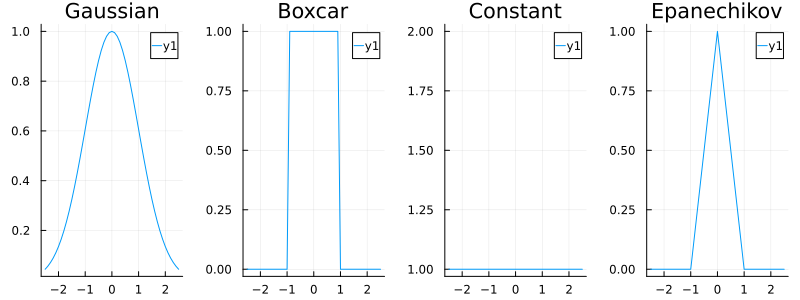

In [16]:

function gaussian(x)
    return exp.(-(x.^2) ./ 2)
end

function boxcar(x)
    return abs.(x) .< 1.0 .|> Float64
end

function constant(x)
    return ones(size(x)...)
end

function epanechikov(x)
    max.(1.0 .- abs.(x), zero(x))
end

kernels = (gaussian, boxcar, constant, epanechikov)
names = ("Gaussian", "Boxcar", "Constant", "Epanechikov")
x = collect(-2.5:0.1:2.5)
plts = map(kernels, names) do kernel, name 
    plot(x, kernel(x), title = name)
end
plot(plts..., layout = (1,4), size = (800, 300))

Different kernels correspond to different notions of range and smoothness. For instance, the boxcar kernel only attends to observations within a distance of $1$ (or some otherwise defined hyperparameter) and does so indiscriminately. 

To see Nadaraya--Watson estimation in action, let's define some training data. In the following we use the dependency

$$y_i = 2\sin(x_i) + x_i + \epsilon,$$

where $\epsilon$ is drawn from a normal distribution with zero mean and unit variance. We draw 40 training examples.


In [18]:
function f(x)
    return 2.0 .* sin.(x) + x 
end

n = 40 
x_train = sort(rand(n)*5)
y_train = f.(x_train) + randn(n)
x_val = 0:0.1:5
y_val = f(x_val);

## Attention Pooling via Nadaraya--Watson Regression

Now that we have data and kernels, all we need is a function that computes the kernel regression estimates. Note that we also want to obtain the relative kernel weights in order to perform some minor diagnostics. Hence we first compute the kernel between all training features (covariates) `x_train` and all validation features `x_val`. This yields a matrix, which we subsequently normalize. When multiplied with the training labels `y_train` we obtain the estimates.

Recall attention pooling in :eqref:`eq_attention_pooling`. Let each validation feature be a query, and each training feature--label pair be a key--value pair. As a result, the  normalized relative kernel weights (`attention_w` below) are the *attention weights*.


In [20]:
function nadaraya_watson(x_train, y_train, x_val, kernel)
    dists = reshape(x_train, :, 1) .- reshape(x_val, 1, :)
    k = kernel(dists)
    attention_w = k ./ sum(k, dims = 1)
    y_hat = y_train'*attention_w |> vec, attention_w
end

nadaraya_watson (generic function with 1 method)

Let's have a look at the kind of estimates that the different kernels produce.


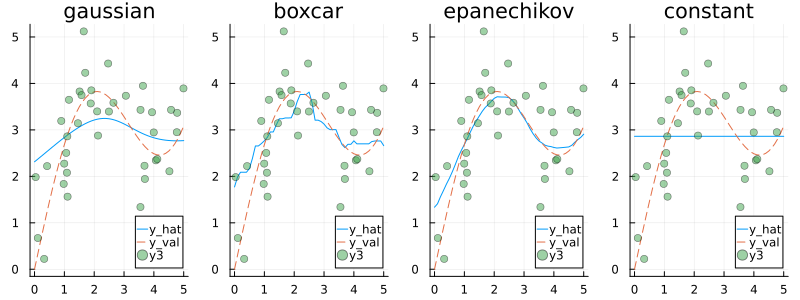

In [22]:
function _plot(x_train, y_train, x_val, y_val, kernels, names, attention = false)
    plts = map(1:length(names), kernels, names) do i, kernel, name 
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention 
            i != length(names) && return heatmap(attention_w; legend = :none)
            return heatmap(attention_w)
        end
        plt = plot(x_val, y_hat, label = "y_hat", title = name)
        plot!(plt, x_val, y_val, linestyle = :dash, label = "y_val")
        plot!(plt, x_train, y_train, linetype = :scatter, markersize=4., alpha = 0.5)
    end
    plot(plts..., layout = (1, 4), legend = :bottomright, size = (800, 300))
end

names = ("gaussian", "boxcar", "epanechikov", "constant")
kernels = (gaussian, boxcar, epanechikov, constant)
p = _plot(x_train, y_train, x_val, y_val, kernels, names)


The first thing that stands out is that all three nontrivial kernels (Gaussian, Boxcar, and Epanechikov) produce fairly workable estimates that are not too far from the true function. Only the constant kernel that leads to the trivial estimate $f(x) = \frac{1}{n} \sum_i y_i$ produces a rather unrealistic result. Let's inspect the attention weighting a bit more closely:


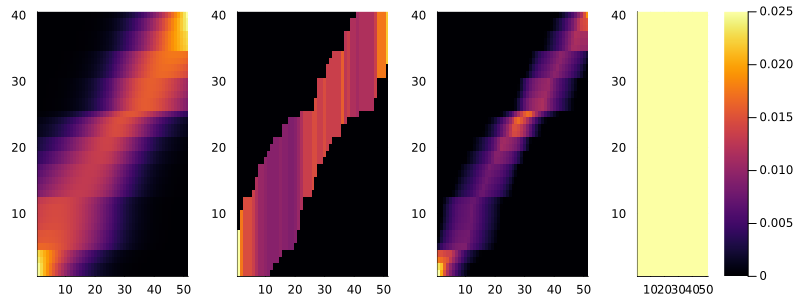

In [23]:
p = _plot(x_train, y_train, x_val, y_val, kernels, names, true)


The visualization clearly shows why the estimates for Gaussian, Boxcar, and Epanechikov are very similar: after all, they are derived from very similar attention weights, despite the different functional form of the kernel. This raises the question as to whether this is always the case.



## Adapting Attention Pooling

We could replace the Gaussian kernel with one of a different width. That is, we could use 
$\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$ where $\sigma^2$ determines the width of the kernel. Let's see whether this affects the outcomes.


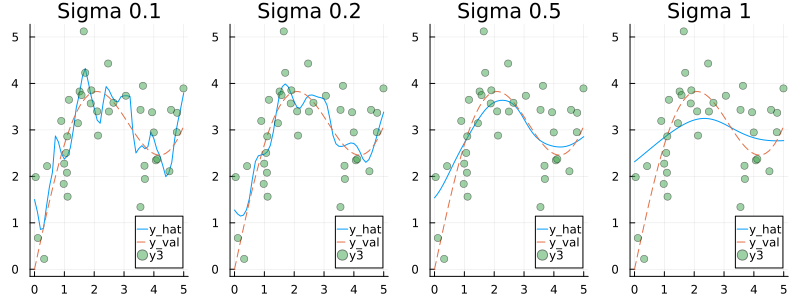

In [27]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ["Sigma "*string(sigma) for sigma in sigmas]

function gaussian_with_sigma(sigma)
    return x -> exp.(-(x.^2) ./ (2*(sigma.^2)))
end
kernels = [gaussian_with_sigma(sigma) for sigma in sigmas]
p = _plot(x_train, y_train, x_val, y_val, kernels, names)


Clearly, the narrower the kernel, the less smooth the estimate. At the same time, it adapts better to the local variations. Let’s look at the corresponding attention weights.



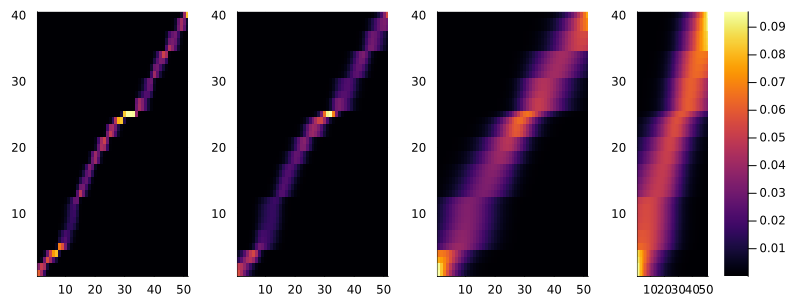

In [28]:
p = _plot(x_train, y_train, x_val, y_val, kernels, names, true)


As we would expect, the narrower the kernel, the narrower the range of large attention weights. It is also clear that picking the same width might not be ideal. In fact, :citet:`Silverman86` proposed a heuristic that depends on the local density. Many more such "tricks" have been proposed. For instance, :citet:`norelli2022asif` used a similar nearest-neighbor interpolation technique for designing cross-modal image and text representations. 

The astute reader might wonder why we are providing this deep dive for a method that is over half a century old. First, it is one of the earliest precursors of modern attention mechanisms. Second, it is great for visualization. Third, and just as importantly, it demonstrates the limits of hand-crafted attention mechanisms. A much better strategy is to *learn* the mechanism, by learning the representations for queries and keys. This is what we will embark on in the following sections.


## Summary

Nadaraya--Watson kernel regression is an early precursor of the current attention mechanisms. 
It can be used directly with little to no training or tuning, either for classification or regression. 
The attention weight is assigned according to the similarity (or distance) between query and key, and according to how many similar observations are available. 

## Exercises

1. Parzen windows density estimates are given by $\hat{p}(\mathbf{x}) = \frac{1}{n} \sum_i k(\mathbf{x}, \mathbf{x}_i)$. Prove that for binary classification the function $\hat{p}(\mathbf{x}, y=1) - \hat{p}(\mathbf{x}, y=-1)$, as obtained by Parzen windows is equivalent to Nadaraya--Watson classification. 
1. Implement stochastic gradient descent to learn a good value for kernel widths in Nadaraya--Watson regression. 
    1. What happens if you just use the above estimates to minimize $(f(\mathbf{x_i}) - y_i)^2$ directly? Hint: $y_i$ is part of the terms used to compute $f$.
    1. Remove $(\mathbf{x}_i, y_i)$ from the estimate for $f(\mathbf{x}_i)$ and optimize over the kernel widths. Do you still observe overfitting?
1. Assume that all $\mathbf{x}$ lie on the unit sphere, i.e., all satisfy $\|\mathbf{x}\| = 1$. Can you simplify the $\|\mathbf{x} - \mathbf{x}_i\|^2$ term in the exponential? Hint: we will later see that this is very closely related to dot product attention. 
1. Recall that :citet:`mack1982weak` proved that Nadaraya--Watson estimation is consistent. How quickly should you reduce the scale for the attention mechanism as you get more data? Provide some intuition for your answer. Does it depend on the dimensionality of the data? How?

